In [1]:
# add repo path to the system path
from pathlib import Path
import os, sys
repo_path= Path.cwd().resolve()
while '.gitignore' not in os.listdir(repo_path): # while not in the root of the repo
    repo_path = repo_path.parent #go up one level
sys.path.insert(0,str(repo_path)) if str(repo_path) not in sys.path else None

import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt

# Original in-pieces idea

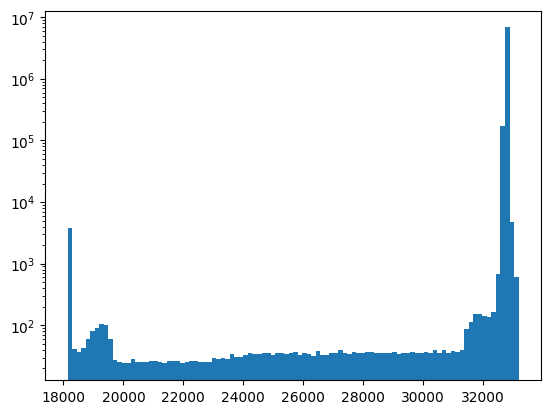

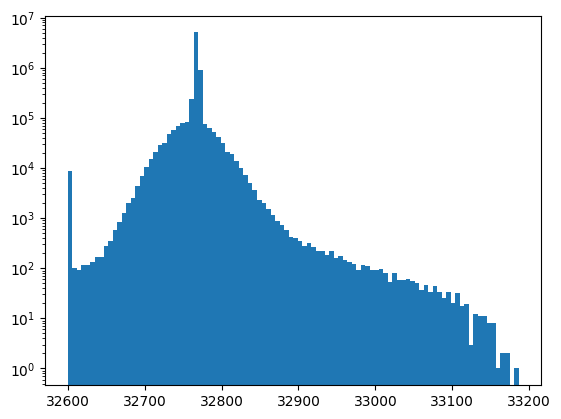

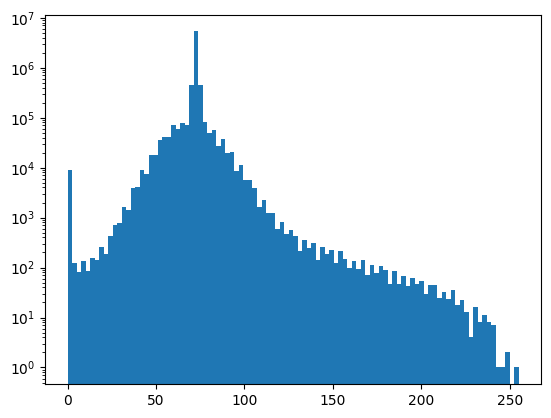

In [136]:
# read example image
image_path = repo_path / 'data/images/SET/Pat_2_SET_SMC_to_CMC_1min.tif'
# read image
im_sitk = sitk.ReadImage(str(image_path))
# get image array
im_array = sitk.GetArrayFromImage(im_sitk)

# show image histogram in log scale
plt.hist(im_array.flatten(),bins=100,log=True)
plt.show()

# send to 32600 all pixels below that value
im_array[im_array<32600] = 32600
# show image histogram
plt.hist(im_array.flatten(),bins=100, log=True)
plt.show()

# map im_array to 256 pixels
im_array = (im_array - np.min(im_array)) / (np.max(im_array) - np.min(im_array))
im_array = (im_array * 255).astype(np.uint8)
# show image histogram
plt.hist(im_array.flatten(),bins=100, log=True)
plt.show()

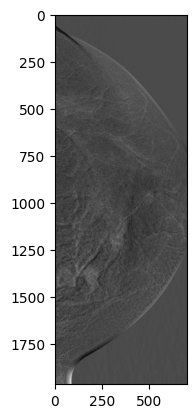

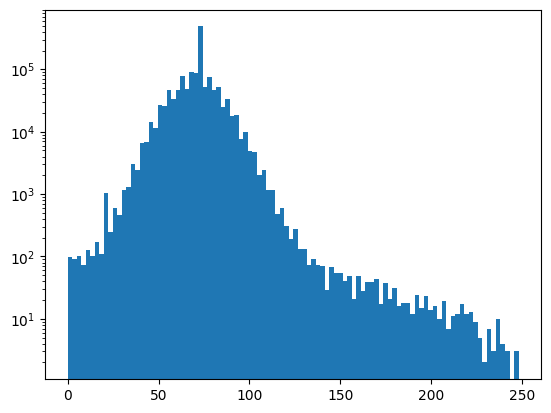

In [18]:
# crop image
im_array_cropped = im_array[500:-500,0:700]
# show image
plt.imshow(im_array_cropped, cmap='gray')
plt.show()
# show image histogram
plt.hist(im_array_cropped.flatten(),bins=100, log=True)
plt.show()

In [17]:
# turn into png image and save
im_png = sitk.GetImageFromArray(im_array_cropped)
png_path = repo_path / 'deep/data' / 'Pat_example.png'
sitk.WriteImage(im_png,str(png_path))

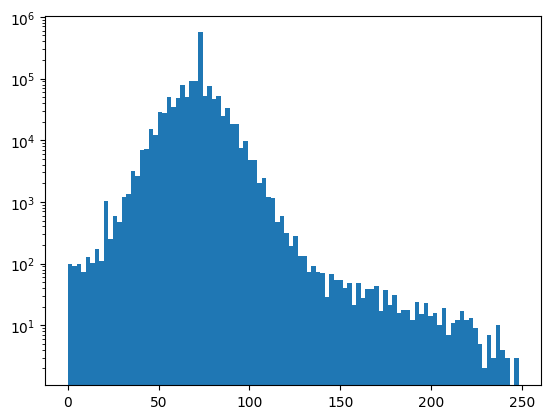

In [9]:
# read saved image and check histogram, as well as pixel values
im_png_read = sitk.ReadImage(str(png_path))
im_array_read = sitk.GetArrayFromImage(im_png_read)
# show image histogram
plt.hist(im_array_read.flatten(),bins=100, log=True)
plt.show()


# Image preprocessing for DBT-Detectron2

Points to consider:
- Pixel intensity: All should be the same, as the physical meaning is supposted to be preserved.
    - Min: 168?
    - Max: 232?
    - Range: 400
- All patients in?
    - Some problematic patients may just add noise and confuse the model.
        1. Patient 4: Veyr very subtle iodine intake
        2. Patient 7: ok...

In [2]:
from utils import dataset_INCan, patient
from scipy import stats
import cv2 as cv

Define well the pixel intensity range.

With plots

Text(0.5, 1.0, 'Patient 38 SET image histogram 8 bits')

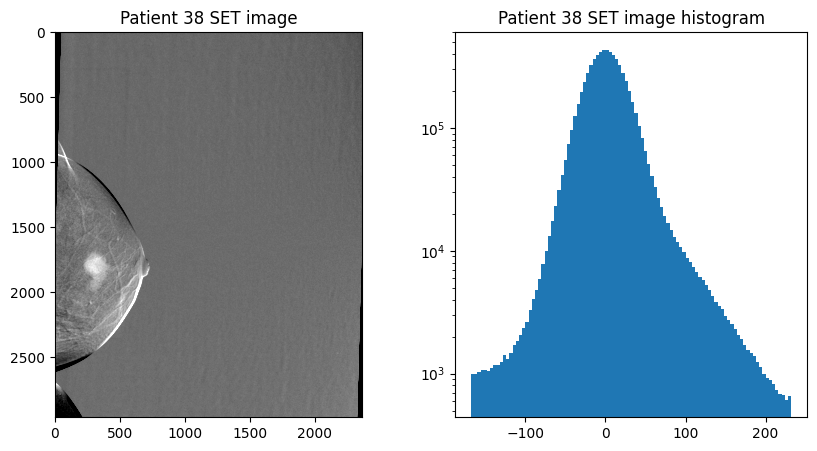

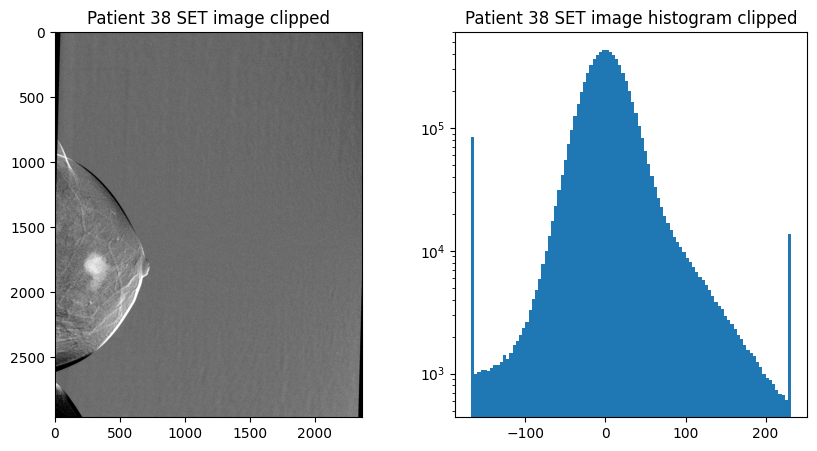

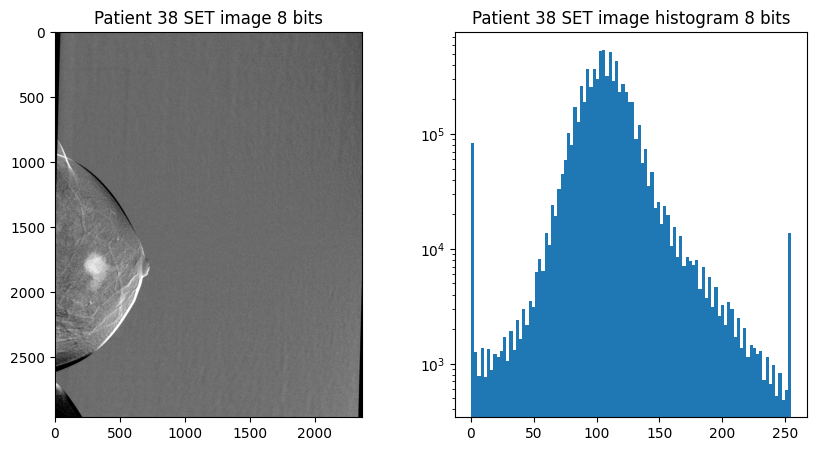

In [3]:
dataset_info = dataset_INCan()
pat_num = dataset_info.pat_num[-8]
patient_ex = patient(pat_num)

# define min and max values for the images
min_val = -168 # -150
max_val = 232 # 300


# read SET image
SET_array = patient_ex.get_im(sequence='SET', format='np', SET_corrected=True, left_oriented=True)

# plot image
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].imshow(SET_array, cmap='gray', vmin=min_val, vmax=max_val)
ax[0].set_title(f'Patient {pat_num} SET image')
# plot histogram
ax[1].hist(SET_array.flatten(), bins=100, log=True, range=(min_val, max_val))
ax[1].set_title(f'Patient {pat_num} SET image histogram')

# send to min value all piel below that value
SET_array[SET_array<min_val] = min_val
# same for max value
SET_array[SET_array>max_val] = max_val
# plot image
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].imshow(SET_array, cmap='gray', vmin=min_val, vmax=max_val)
ax[0].set_title(f'Patient {pat_num} SET image clipped')
# plot histogram
ax[1].hist(SET_array.flatten(), bins=100, log=True, range=(min_val, max_val))
ax[1].set_title(f'Patient {pat_num} SET image histogram clipped')

# map im_array to 256 pixels
SET_array = (SET_array - np.min(SET_array)) / (np.max(SET_array) - np.min(SET_array))
SET_array = (SET_array * 255).astype(np.uint8)
# plot image
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].imshow(SET_array, cmap='gray', vmin=0, vmax=255)
ax[0].set_title(f'Patient {pat_num} SET image 8 bits')
# plot histogram
ax[1].hist(SET_array.flatten(), bins=100, log=True, range=(0, 255))
ax[1].set_title(f'Patient {pat_num} SET image histogram 8 bits')


Get the bbox of the breast

In [4]:
def prepare_array(array:np.array, min_val:int, max_val:int):
    """map array to the range 0-255, and clip values below min_val and above max_val

    Args:
        array (np.array): image array
        min_val (int): min value to clip
        max_val (int): max value to clip

    Returns:
        np.array: image array clipped and mapped to 0-255
    """
    # send to min value all piel below that value
    array[array<min_val] = min_val
    # same for max value
    array[array>max_val] = max_val
    # map im_array to 256 pixels
    array = (array - np.min(array)) / (np.max(array) - np.min(array))
    array = (array * 255).astype(np.uint8)
    return array

def get_normal_BBox (im_array:np.array):
    """Given an mammogram image, returns the bounding box of the breast

    Args:
        im_array (np.array): array of the mammogram image, with background black

    Returns:
        tuple, array: bounding box coordinates, and image with the breast only
    """
    #threshold im_array 
    img = cv.threshold(im_array, 0, 255, cv.THRESH_BINARY)[1]  # ensure binary
    nb_components, output, stats, _ = cv.connectedComponentsWithStats(img, connectivity=4)
    sizes = stats[:, -1]
    max_label = 1
    max_size = sizes[1]
    for i in range(2, nb_components):
        if sizes[i] > max_size:
            max_label = i
            max_size = sizes[i]
    img2 = np.zeros(output.shape,dtype=np.uint8)
    img2[output == max_label] = 255
    contours, _ = cv.findContours(img2,cv.RETR_TREE,cv.CHAIN_APPROX_NONE)

    cnt = contours[0]

    x,y,w,h = cv.boundingRect(cnt)
    
    return (x,y,x+w,y+h), img2

def get_bbox_cedm(SET_array:np.array):
    """Given an SET image, returns the bounding box of the breast

    Args:
        SET_array (np.array): SET array in original format

    Returns:
        tuple: bounding box coordinates
    """
    SET_mode = stats.mode(SET_array[SET_array!=0].flatten(), keepdims=True)[0][0]
    # send pixels to 0 in the mode
    SET_array_blackbg = SET_array.copy()
    SET_array_blackbg[SET_array_blackbg==SET_mode] = 0
    # also remove +-range the mode in one line
    for i in range(7):
        SET_array_blackbg[(SET_array_blackbg==SET_mode+i) | (SET_array_blackbg==SET_mode-i)] = 0

    bbox, _ = get_normal_BBox(SET_array_blackbg)

    return bbox

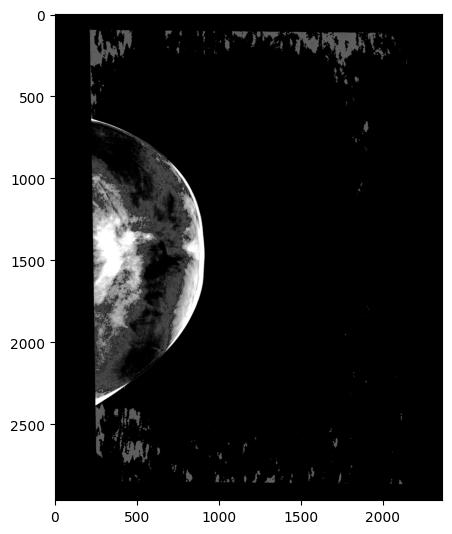

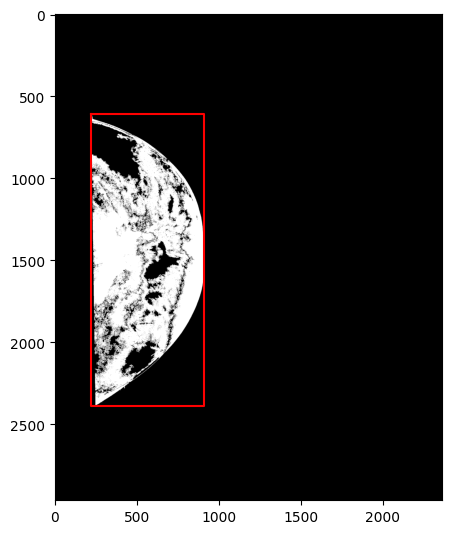

In [12]:
### Summary
dataset_info = dataset_INCan()
# define min and max values for the images
min_val = -168
max_val = 232
# example
pat_num = dataset_info.pat_num[5]
patient_ex = patient(pat_num)
# read SET image, left oriented and corrected
SET_array = patient_ex.get_im(sequence='SET', format='np', SET_corrected=True, left_oriented=True)
SET_array = prepare_array(SET_array, min_val, max_val) # to 8bits in range

# CUTTING
# find most common value
SET_mode = stats.mode(SET_array[SET_array!=0].flatten(), keepdims=True)[0][0] # mode cannot be zero
# send pixels to 0 in the mode
SET_array_blackbg = SET_array.copy()
SET_array_blackbg[SET_array_blackbg==SET_mode] = 0
# also remove +-range the mode in one line
for i in range(11):
    SET_array_blackbg[(SET_array_blackbg==SET_mode+i) | (SET_array_blackbg==SET_mode-i)] = 0
# show image
plt.figure(figsize=(5,10))
plt.imshow(SET_array_blackbg, cmap='gray')
plt.show()

bbox, img2 = get_normal_BBox(SET_array_blackbg)

# show image
plt.figure(figsize=(5,10))
plt.imshow(img2, cmap='gray')
# show bbox
plt.plot([bbox[0],bbox[2],bbox[2],bbox[0],bbox[0]],[bbox[1],bbox[1],bbox[3],bbox[3],bbox[1]],'r')
plt.show()


Extract the breast and save image

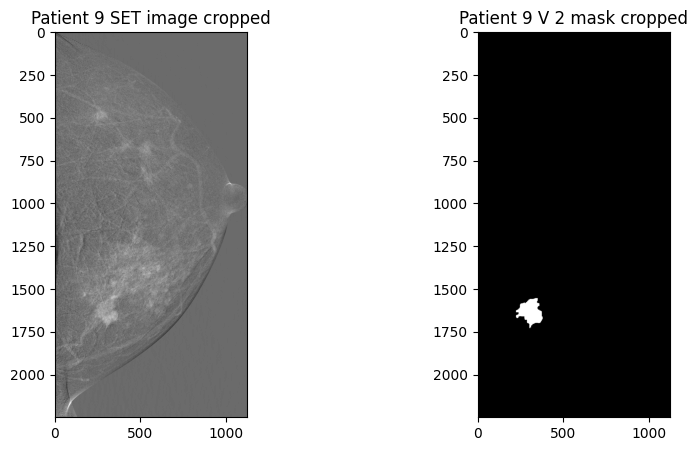

In [19]:
### Summary
dataset_info = dataset_INCan()
# define min and max values for the images
min_val = -168
max_val = 232

# example
pat_num = dataset_info.pat_num[6]
patient_ex = patient(pat_num)
# read SET image, left oriented and corrected
SET_array = patient_ex.get_im(sequence='SET', format='np', SET_corrected=True, left_oriented=True)
SET_array = prepare_array(SET_array, min_val, max_val) # to 8bits in range

# get bbox
bbox = get_bbox_cedm(SET_array)

# CROP IMAGES and MASKS
SET_array_cropped = SET_array[bbox[1]:bbox[3],bbox[0]:bbox[2]]
# save image as png
im_png = sitk.GetImageFromArray(SET_array_cropped)
png_path = repo_path / 'deep/data' / 'Pat_example.png'
sitk.WriteImage(im_png, str(png_path))

for rad in ['L','M', 'V']:
    for time in ['1','2']:
        mask_array = patient_ex.get_seg(rad=rad, time=time, left_oriented=True)
        mask_array_cropped = mask_array[bbox[1]:bbox[3],bbox[0]:bbox[2]]
        # send values of 1 to 255
        mask_array_cropped[mask_array_cropped==1] = 255
        # save image as png
        im_png = sitk.GetImageFromArray(mask_array_cropped)
        png_path = repo_path / 'deep/data' / f'Pat_example_mask_{rad}_{time}.png'
        sitk.WriteImage(im_png, str(png_path))

# show image and mask
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].imshow(SET_array_cropped, cmap='gray')
ax[0].set_title(f'Patient {pat_num} SET image cropped')
# show binary mask
ax[1].imshow(mask_array_cropped, cmap='gray')
ax[1].set_title(f'Patient {pat_num} {rad} {time} mask cropped')
plt.show()


# bbox from the mask

We have the images and the masks cutted. Now it is time to use them for feature extraction.<br>
We try the first idea:

3. Extract the 1024 feature vector from the DBT heads.
    - A first trial is to extract features from the full ROI around the lesion. We select Vyanka 1 for this purpose.

In [49]:
# example image and mask
im_path = repo_path / 'data/deep/images/Pat_2_SET.png'
mask_path = repo_path / 'data/deep/G_masks/Pat_2_mask_V_1.png'
# read
im_sitk = sitk.ReadImage(str(im_path))
im_array = sitk.GetArrayFromImage(im_sitk)
mask_sitk = sitk.ReadImage(str(mask_path))
mask_array = sitk.GetArrayFromImage(mask_sitk)

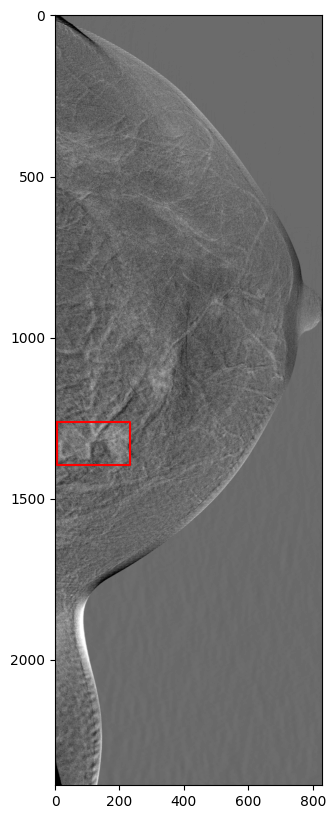

In [54]:
# create a bbox around the binary mask
bbox, _ = get_normal_BBox(mask_array)
# show bbox in image
plt.figure(figsize=(5,10))
plt.imshow(im_array, cmap='gray')
plt.plot([bbox[0],bbox[2],bbox[2],bbox[0],bbox[0]],[bbox[1],bbox[1],bbox[3],bbox[3],bbox[1]],'r')
plt.show()